##Lecture 8: 1D Convolutional Networks

Convolution involves sliding a "kernel" function along the data:
\begin{equation}
  y(t) = \int x(t-\tau) h(\tau) d\tau
\end{equation}
and remember that $h$ is running backward, while $x$ is moving forward in this equation.  In discrete time:
\begin{equation}
  y(t) = \sum_\tau x(t-\tau) h(\tau)
\end{equation}
If $h(\tau) = 0 $ whenever $\tau < 0$ then the convolution is "causal" in the sense that it depends only on past values of $x$.

Convolution is a linear operator, in the sense that 
\begin{equation}
  h*(x+z) = h*x + h*z
\end{equation}
so this means that it can be represented by a matrix operation:
\begin{equation}
  h*x \sim Wx
\end{equation}
where the matrix $W$ is a "Toeplitz" matrix which means that all the diagonals are constant:
\begin{equation}
 Wx \sim  \left[
     \begin{array}{c}
     y_0 \\ y_1 \\ y_2 \\ y_3 \\y_4
     \end{array}
     \right] = \left[ 
   \begin{array}{ccccc}
   1 & .5 & 0 & 0 & 0\\
   .5 & 1 & .5 & 0 & 0 \\
   0 & .5 & 1 & .5 & 0 \\
   0& 0 & .5 & 1 & .5  \\
   0 & 0 & 0 & .5 & 1 \\
   \end{array} \right]
   \cdot
   \left[
     \begin{array}{c}
     x_0 \\ x_1 \\ x_2 \\ x_3 \\x_4
     \end{array}
     \right] 
      \\
\end{equation}

which corresponds to $h = <0.5, 1, 0.5>$.  The matrix $W$ corresponds to a causal filter if all values above the diagonal are zero.  


Math Moment: If we allow elements that slide off one side of the matrix to re-enter the other side, then we have a "circulant matrix":
\begin{equation}
 \left[ 
   \begin{array}{ccccc}
   1 & .5 & 0 & 0 & 0.5\\
   .5 & 1 & .5 & 0 & 0 \\
   0 & .5 & 1 & .5 & 0 \\
   0& 0 & .5 & 1 & .5  \\
   0.5 & 0 & 0 & .5 & 1 \\
   \end{array} \right]
   \end{equation}
and it is worth noting that the eigenvectors of a circulant matrix are of the form $e^{-2i\pi k/N}$ (sin's and cos's) and the eigenvalues are the Fourier transform of the kernel $h$.


Back to networks:  the difference between a convolution and just a regular linear mapping is the constraint that the rows are all the same except shifted by one.

When we do this in a network, there may be a nonlinearity
\begin{equation}
  y = \sigma(Wx)
\end{equation}
so the only difference between a convolutional network and a regular network is whether or not $W$ is constrained to be Toeplitz.  

A network with multiple outputs might have
\begin{equation}
  y = <h_0 *x,\ldots , h_N*x> \\
   = <W_0x, \ldots, W_Nx>
\end{equation}

To make this more confusing, although we usually think of $x(t)$ as a scalar, for convolutional networks it is better to think of $x(t)$ as a vector $<x_0(t), \ldots, x_M(t)>$ so that there is a vector input at each time point.  Unlike how convolution is used for filtering where we run the convolution over all time, in this case, the convolution is run over the vector $x(t)$ at the current time.  In other words, $y(t) = Wx(t)$ at each point in time, or for multiple outputs we have 
\begin{equation}
  y(t) = <W_0x(t),\ldots, W_Nx(t)>
\end{equation}
where each matrix $W_j$ is $N \times M$.  For instance, if $x(t)$ is a 100-element vector at each point in time, and if there are 4 different convolutions being run at each point in time, then $y(t)$ has 400 elements $y_{ij}(t)$ at each point in time, where $y_{ij}$ is the $j'th$ point in the convolution given by $W_i$. 

If we want a single scalar output $z(t)$ at each time, then we might add another layer to the network:
\begin{equation}
  z(t) = \sigma \left( \sum_{i=0}^M \sum_{j=0}^N v_{ij} \sigma (y_{ij}) \right)
\end{equation}

Why would we use the convolution constraint on the weights?  Here are some reasons:
1. Training is faster because there are fewer weights to train.
2. The network does the same thing at each point in time (within the $x(t)$ vector), which makes sense for time-invariant systems.
3. Forward propagation is faster because it can use convolution operations and does not have to store as many weights.
4. In some cases, we can speed things up using Fourier transforms.





In [43]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

# Filtering EMG again
We will use the EMG/force dataset again here so that we can compare with the nonlinear filter.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


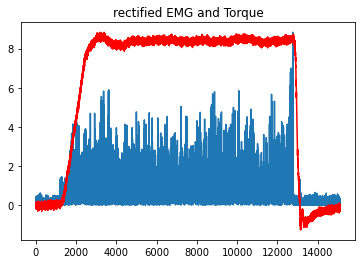

In [45]:
#load the sample EMG data
arEMG = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/EMGdata.csv')
dfEMG = pd.DataFrame(arEMG)
ws = dfEMG['Torque'].to_numpy()
ws = ws - ws[0:200].mean()  #use the first few points to find zero
ms = dfEMG['Biceps'].to_numpy()
ms = ms - ms[0:200].mean()  #use the first few points to find zero
ms = np.absolute(ms)  #rectify the EMG
time_points = len(ws)

#scale the range this time because we will be using the raw data as input to the network
#  we have already removed the means; just scale so that standard deviation is 1
modulated_signal = ms / np.std(ms)
wave_signal = ws / np.std(ws)

plt.figure()
plt.plot(modulated_signal)
plt.plot(wave_signal * modulated_signal.max()/wave_signal.max(),'r')
plt.title('rectified EMG and Torque');


#Model1: Distributed output

For the first try, use the distributed encoding that we used last time, although this is a very different type of filter.

<Figure size 1008x72 with 0 Axes>

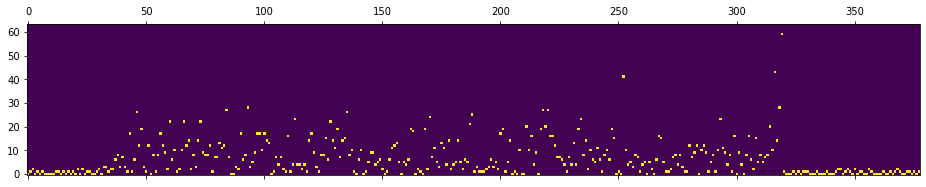

<Figure size 1008x72 with 0 Axes>

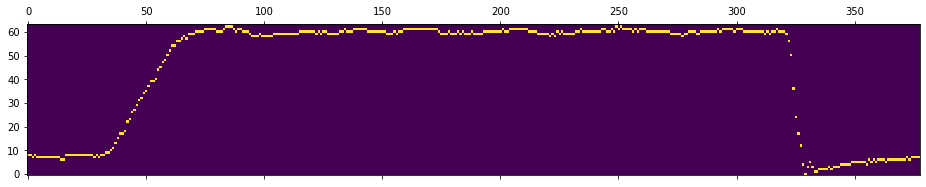

In [46]:
#encode the state in a state vector representing the probabilities.  These are the actual measured states, so prob=1 for the correct state
#some people use the term "one-hot" for this type of encoding, based on concepts from commercial electrical wiring
def to_distributed(data, nstates=128, timepoints=1000):
  d = data - min(data)
  dscale = ((nstates-1)*d/np.max(d))
  vec = np.zeros((timepoints, nstates), dtype = int)
  vec[np.arange(timepoints),dscale.astype(int)] = 1
  return vec

#turn into probability vectors
#we are only going to use this for the output; do not need to encode the input for this type of network
n_states = 64   #this is arbitrary. sets the precision
vModulated = to_distributed(modulated_signal, n_states, time_points)
dfModulated = pd.DataFrame(data=vModulated, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.matshow(vModulated[np.arange(0,time_points,40)].transpose(), origin = 'lower')
vWave = to_distributed(wave_signal, n_states, time_points)
dfWave = pd.DataFrame(data=vWave, index=np.arange(time_points)) 
plt.figure(figsize=(14,1))
plt.matshow(vWave[np.arange(0,time_points,40)].transpose(), origin = 'lower');

For convolutional networks, the input $x(t)$ at each time $t$ is a vector, and the convolution will run along this vector (not along the time axis).  However, in this case each $x(t)$ is going to be a short window of the actual input time series $s(t)$.  In other words, we will set $x(t) = <s(t), s(t-1), \ldots, s(t-N)>$ at each time.  $x(t)$ then "slides" along the actual input data.

This is exactly what we have done in the past when we created FIR filters. TimeSeriesGenerator does this for us, providing lagged values of the input series as the network inputs.  The difference here is that we have a different calculation being done on the lagged series.  Whereas an FIR filter simply takes the dot product of the input with a filter vector $y(t) = f \dot x(t)$, a convolutional network has an intermediate multivariate layer $y_i(t) = h_i*x(t)$ where each $y_i(t)$ is a vector of the same length as $x(t)$.  Then there is an output layer that combines the values of $y_{ij}(t)$ to produce the final network output $z(t) = \sigma \left(\sum_{ij} \sigma (y_{ij}(t)) \right)$.

In [47]:
#generator will product short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 40  #in this case, this is the length of the vector x(t)
predict_point = 20   #half of predict_length.  We will make a noncausal filter where we predict z(t) from <s(t-N/2) ... s(t+N/2)>
batch_size = 1       #one sample at a time for network training
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)   #TimeSeriesGenerator always tries to predict the next point
          #this corrects so that it is predicting the middle point.
generator = TimeseriesGenerator(modulated_signal, dfTarget.values, length = predict_length, batch_size=batch_size) #don't forget to use .values for any dataframe or will fail in model.fit()
generator[0][0].shape  #note the shape: (batch_size, predict_length)


(1, 40)

In [48]:
#build the network
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv1D, Reshape
from tensorflow.keras.layers import MaxPooling1D, GlobalAveragePooling1D  #useful for combining the outputs of convolution layers

window_size = predict_length   #better to think of this as a sliding window onto the input series
len_conv_window = 5            #how many points in the convolution kernel h
n_conv_units = 20              #how many different convolution kernels h_i 
n_sensors = 1                  #in this case, we just use a single sensor from the biceps.
model = Sequential()
#note that generator supplies row vectors, but Conv1D expects a column vector.  Use Reshape layer to transpose
model.add(Reshape((predict_length,n_sensors),input_shape=(n_sensors,predict_length)))
#there will be n_conv_units for each point in time.  put sigmoids on the output of each one
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten())  #so that the linear layer produces a single set of outputs
model.add(Dense(n_states, activation='softmax'))  #going to use a one-hot output encoding
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 40, 1)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 20)            120       
                                                                 
 flatten_3 (Flatten)         (None, 720)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                46144     
                                                                 
Total params: 46,264
Trainable params: 46,264
Non-trainable params: 0
_________________________________________________________________


The number of conv1d parameters is n_conv_units * len_conv_window + len_conv_units (bias) = 20 * 5 + 20.  Note that it does NOT depend on predict_length, because the weights are the same for every point in predict_length.  The reason that the length of the output is 36 instead of 40 is that the convolution requires 5 inputs, so the last 4 outputs are not valid.  In general, the time length of the output of a convolution is predict_length - len_conv_window + 1

Epoch 1/5
15076/15076 [==============================] - 35s 2ms/step - loss: 2.2170
Epoch 2/5
15076/15076 [==============================] - 35s 2ms/step - loss: 2.0975
Epoch 3/5
15076/15076 [==============================] - 33s 2ms/step - loss: 2.0718
Epoch 4/5
15076/15076 [==============================] - 33s 2ms/step - loss: 2.0534
Epoch 5/5
15076/15076 [==============================] - 34s 2ms/step - loss: 2.0448


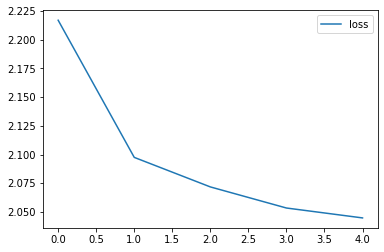

In [49]:
#generator has trouble with the first few examples so we get warnings.  does not seem to affect the results.
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [50]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


ML rms_error 0.5194021974159255
MMSE rms_error 0.5202773855449297


<Figure size 1008x288 with 0 Axes>

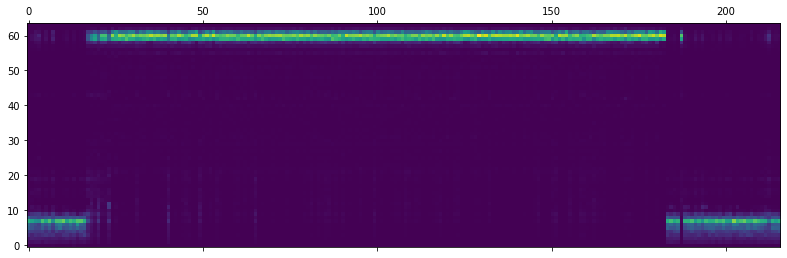

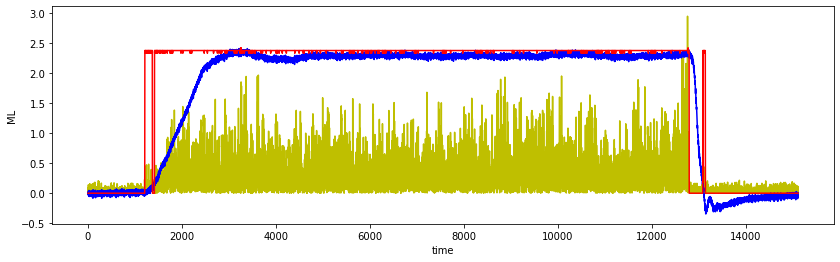

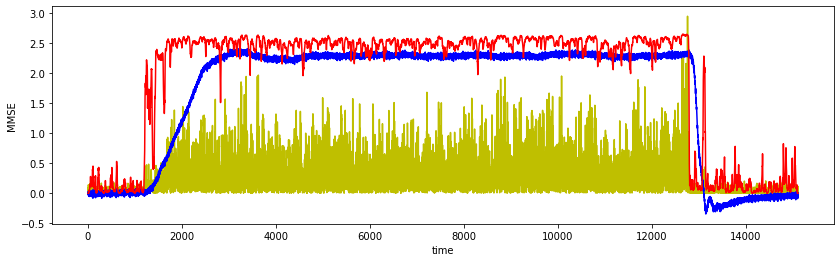

In [51]:
#because we used a distributed (one-hot) output encoding, need to find the peaks or the mean to get a scalar output
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)


#first show the estimate probability distribution (raw output of the network)
plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('MMSE rms_error {}'.format(rms_error));

Note that the ML estimate did much better than the MMSE estimate, or at least seems to have less noise.  This is because the averaging operation is very sensitive to outliers and small fluctuations in the data.  Also, the network was trained using the categorical_crossentropy loss, which means that it was optimized for an ML readout, not and MMSE readout.  

#Model 2: scalar output

So to compare, let's do the same thing again but not using the distributed output.

In [52]:
#generator will product short windows of the data
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 40
predict_point = 20
batch_size = 1
#only difference here is that the output target is a scalar value rather than distributed
#still have to insert some zeros in order to have a non-causal filter
target = np.insert(wave_signal,0,np.zeros(predict_point))
generator = TimeseriesGenerator(modulated_signal, target[0:len(modulated_signal)], length = predict_length, batch_size=batch_size)
generator[0]

(array([[0.1090124 , 0.13250653, 0.15292461, 0.01174526, 0.2752221 ,
         0.04468212, 0.04314229, 0.03216694, 0.11999135, 0.41793407,
         0.24228524, 0.13096671, 0.04314229, 0.03216694, 0.17487891,
         0.04314229, 0.19683681, 0.13096671, 0.09803345, 0.13250653,
         0.0651002 , 0.09956968, 0.13250653, 0.02272422, 0.01020904,
         0.35053133, 0.15292461, 0.14194566, 0.15446083, 0.01174526,
         0.11999135, 0.15292461, 0.02272422, 0.01174526, 0.05565747,
         0.04314229, 0.15292461, 0.17641873, 0.07761537, 0.47282522]]),
 array([0.04615393]))

In [53]:
window_size = predict_length
len_conv_window = 5
n_conv_units = 20
n_sensors = 1
model = Sequential()
#model.add(Flatten(input_shape = (1,predict_length)))
model.add(Reshape((predict_length,n_sensors),input_shape=(n_sensors,predict_length)))
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))  #note there is only a single (linear) output
model.compile(optimizer='adam', loss='mse')   #in this case, use mse loss because we do not have a distributed output that looks like a probability
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 40, 1)             0         
                                                                 
 conv1d_4 (Conv1D)           (None, 36, 20)            120       
                                                                 
 flatten_4 (Flatten)         (None, 720)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 721       
                                                                 
Total params: 841
Trainable params: 841
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
15076/15076 [==============================] - 35s 2ms/step - loss: 0.2773
Epoch 2/5
15076/15076 [==============================] - 32s 2ms/step - loss: 0.2296
Epoch 3/5
15076/15076 [==============================] - 31s 2ms/step - loss: 0.2215
Epoch 4/5
15076/15076 [==============================] - 31s 2ms/step - loss: 0.2142
Epoch 5/5
15076/15076 [==============================] - 30s 2ms/step - loss: 0.2084


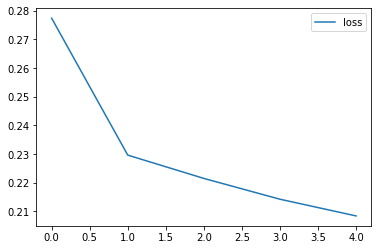

In [54]:
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [55]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


Scalar output rms_error 1.4181834895354197


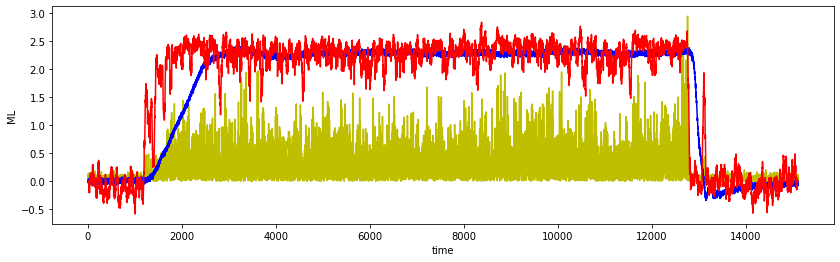

In [56]:
predict = dfPredict.values   #do not have to do ML or MMSE calculation here
predict -= predict[0:200].mean()
predict *= wave_signal.std()/predict.std()

predict = np.append(predict, np.zeros(predict_point).reshape(predict_point,1), axis=0)
predict = np.append(np.zeros(predict_point).reshape(predict_point,1), predict, axis=0)

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict,'r')
plt.ylabel('ML')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict-wave_signal)))
print('Scalar output rms_error {}'.format(rms_error));



The result looks a lot like the MMSE prediction from before.  That makes sense, because it is basically what the network is trying to do.  Small variations in the input will lead to small variations in the output, so there will always be some noise that gets through.  In an ML readout that does not happen, because finding the index is like a quantizing operation and quantizing rejects small amounts of noise.

#Model 3: Multivariate input

Let's add a second input variable.  By including both the biceps and the triceps, we might have a better estimate of joint torque, because the torque may look like biceps-triceps since they pull in opposite directions. The triceps is not the only force causing elbow extension, and the biceps is not the only force causing elbow flexion, but maybe this would be better by having another variable in the mix.

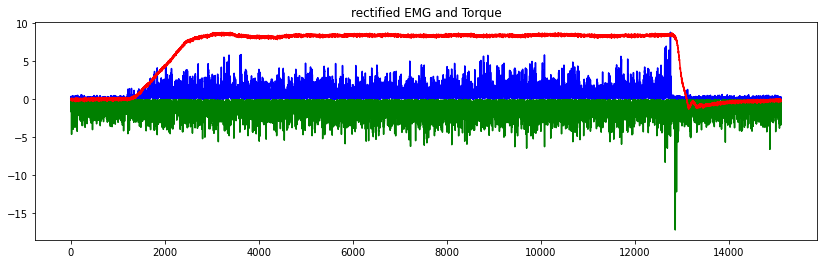

In [57]:
#extract and normalize the triceps data
ts = dfEMG['Triceps'].to_numpy()
ts = ts - ts[0:200].mean()  #use the first few points to find the zero
ts = np.absolute(ts)  #rectify the EMG
triceps_signal = ts / np.std(ts)
#the normalization hides the fact that the amplitude of the triceps is much less than the biceps
#   as a result, it may amplify the noise.  won't matter here, but be aware of differences in scale in your own data.

plt.figure(figsize=(14,4))
plt.plot(modulated_signal,'b')
plt.plot(-triceps_signal,'g')
plt.plot(wave_signal * modulated_signal.max()/wave_signal.max(),'r')
plt.title('rectified EMG and Torque');

In [58]:
predict_length = 40
predict_point = 20
batch_size = 1
dfTarget = dfWave.shift(periods=predict_point, fill_value=0)  #as usual, make this noncausal
time_points = len(modulated_signal)
#combine the biceps and triceps data by making them into column vectors (using reshape) and then joining them horizontally
#  this will create a time x 2 matrix.
dfInput = np.hstack((modulated_signal.reshape(time_points,1), triceps_signal.reshape(time_points,1)))
#use the distributed output here so we can compare the results
generator = TimeseriesGenerator(dfInput, dfTarget.values, length = predict_length, batch_size=batch_size)
generator[0][0].shape   #(batch_size, predict_length, n_sensors)

(1, 40, 2)

In [59]:
window_size = predict_length
len_conv_window = 5
n_conv_units = 40    #increased number of units because of increased number of inputs
n_sensors = 2    #biceps and triceps
model = Sequential()
model.add(Reshape((predict_length,n_sensors),input_shape=(n_sensors,predict_length)))  #needs to be a column vector
model.add(Conv1D(n_conv_units, len_conv_window, activation = 'sigmoid'))
model.add(Flatten())
model.add(Dense(n_states, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 40, 2)             0         
                                                                 
 conv1d_5 (Conv1D)           (None, 36, 40)            440       
                                                                 
 flatten_5 (Flatten)         (None, 1440)              0         
                                                                 
 dense_5 (Dense)             (None, 64)                92224     
                                                                 
Total params: 92,664
Trainable params: 92,664
Non-trainable params: 0
_________________________________________________________________


The number of conv1d parameters is n_sensors * n_conv_units * len_conv_window + n_sensors * len_conv_units (bias) = 2 * 20 * 5 + 2 * 20.  

Epoch 1/5
15076/15076 [==============================] - 35s 2ms/step - loss: 2.1806
Epoch 2/5
15076/15076 [==============================] - 34s 2ms/step - loss: 2.0543
Epoch 3/5
15076/15076 [==============================] - 33s 2ms/step - loss: 2.0245
Epoch 4/5
15076/15076 [==============================] - 32s 2ms/step - loss: 2.0026
Epoch 5/5
15076/15076 [==============================] - 32s 2ms/step - loss: 1.9834


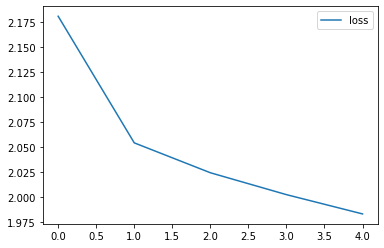

In [60]:
model.fit(generator, epochs=5)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [61]:
predicted_output = model.predict(generator)
dfPredict = pd.DataFrame(data=predicted_output)


Multivariate ML rms_error 0.5523019082007852
Multivariate MMSE rms_error 0.4849817670362392


<Figure size 1008x288 with 0 Axes>

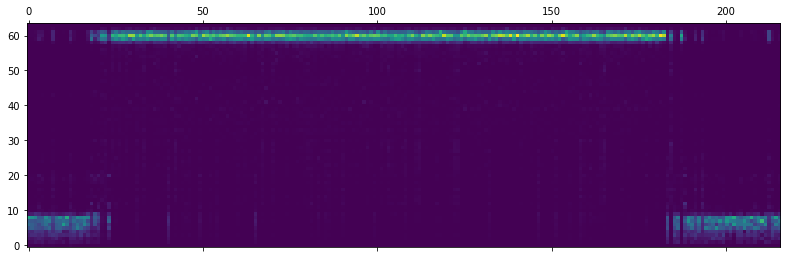

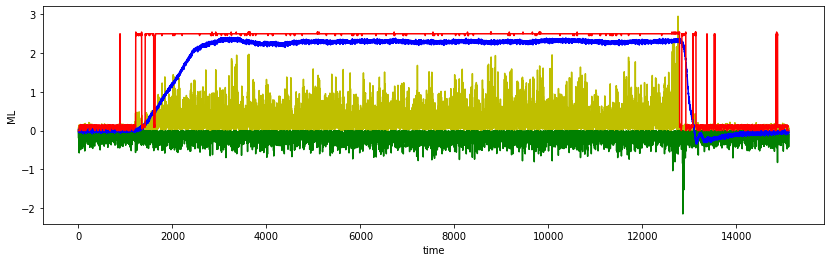

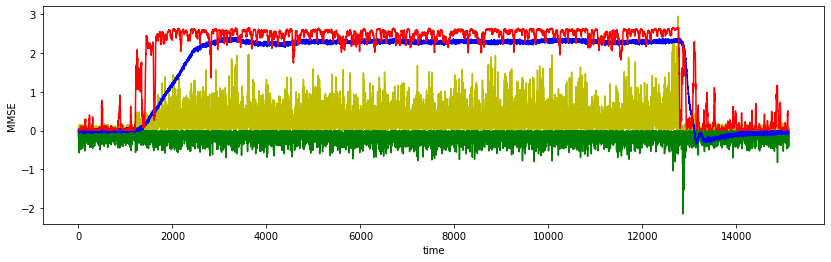

In [62]:
#used distributed output, so need to convert to a scalar value
predict_ML = dfPredict.idxmax(axis=1)
predict_ML -= predict_ML.min()
predict_ML *= wave_signal.std()/predict_ML.std()
predict_MMSE = dfPredict.dot(np.arange(0,n_states))
predict_MMSE -= predict_MMSE.min()
predict_MMSE *= wave_signal.std()/predict_MMSE.std()

predict_ML = np.append(predict_ML, np.zeros(predict_point), axis=0)
predict_ML = np.append(np.zeros(predict_point), predict_ML, axis=0)
predict_MMSE = np.append(predict_MMSE, np.zeros(predict_point), axis=0)
predict_MMSE = np.append(np.zeros(predict_point), predict_MMSE, axis=0)


plt.figure(figsize=(14,4))
plt.matshow(dfPredict.values[0:len(dfPredict):70,:].transpose(), origin = 'lower')

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(-triceps_signal/8,'g')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_ML,'r')
plt.ylabel('ML')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(modulated_signal/3,'y')
plt.plot(-triceps_signal/8,'g')
plt.plot(wave_signal,'b')  #compare one column at a time
plt.plot(predict_MMSE,'r')
plt.ylabel('MMSE')
plt.xlabel('time');

rms_error = np.sqrt(np.mean(np.square(predict_ML-wave_signal)))
print('Multivariate ML rms_error {}'.format(rms_error))
rms_error = np.sqrt(np.mean(np.square(predict_MMSE-wave_signal)))
print('Multivariate MMSE rms_error {}'.format(rms_error));

#Homework 5

Re-run model #1 above with varying values of
window_size:  10, 30, 40
len_conv_window: 2, 10, 20
n_conv_units: 5, 10, 50

Not all combinations will work, and you do not have to use these exact numbers.  Try to get a sense of how the results vary based on the different values, and make a table of the ML and MMSE estimate rms_error for at least 9 different cases.  What conclusions can you draw from the results?
